# MagTrace@HKU
In this notebook, we will provide analysis corresponding to the presentation in-class.

In [11]:
import os
import numpy as np
from dtw import dtw
from scipy.spatial.distance import euclidean
import scipy
from api import MagRetraceData
import api as magretraceapi
import matplotlib.pyplot as plt

## 1. The API and preprocessing functionalities

In [3]:
api = magretraceapi.MagRetraceDataAPI("./data")

### 1.1 Dynamic Time warping & matching

In [4]:
def dtw_process(template, sequence):
    # Ensure that both arrays are 1-D
    template = np.reshape(template, (-1, 1))
    sequence = np.reshape(sequence, (-1, 1))

    # Define the distance function to use (Euclidean distance)
    distance = lambda x, y: euclidean(x, y)

    # Compute the DTW distance between the template and the sequence
    d, cost_matrix, acc_cost_matrix, path = dtw(template, sequence, dist=distance)

    # Extract the matching part of the sequence based on the DTW path
    start, end = path[0][1], path[-1][1]
    matched_sequence = sequence[start:end+1]

    return d, matched_sequence

In [5]:
def sliding_window(sequence: np.ndarray, window_length: int, step: int) -> list[np.ndarray]:
    windows = []
    for i in range(0, len(sequence) - window_length + 1, step):
        window = sequence[i:i+window_length]
        windows.append(window)
    return windows

In [6]:
def downsample(signal_time_seq: np.ndarray, signal: np.ndarray, downsample_factor) -> tuple[np.ndarray]:
    """
    Downsample the signal by the given factor.
    """
    # Compute the downsampled signal.
    signal_downsampled = signal[::downsample_factor]

    # Compute the downsampled time sequence.
    signal_time_seq_downsampled = signal_time_seq[::downsample_factor]

    return signal_time_seq_downsampled, signal_downsampled

In [7]:
def gaussian_filter(signal: np.ndarray, sigma: float):
    return scipy.ndimage.gaussian_filter(signal, sigma=sigma)

In [8]:
def dtw_matching_distance_abs(template: MagRetraceData,
    traversal: MagRetraceData,
    downsampling_coefficient=10,
    windowing_coefficient=1,
    step_coefficient=0.25,
    perform_gaussian_filtering=False,
    gaussian_filter_sigma=1.0):
    # The template at the entrance of CB
    tem_timeseq = template.time_seq
    tem_absmag = template.mag_abs
    tra_timeseq = traversal.time_seq
    tra_absmag = traversal.mag_abs
    
    # Filtering
    if perform_gaussian_filtering:
        tem_absmag = gaussian_filter(tem_absmag, gaussian_filter_sigma)
        tra_absmag = gaussian_filter(tra_absmag, gaussian_filter_sigma)
    
    # Downsampling
    tem_timeseq, tem_absmag = downsample(tem_timeseq, tem_absmag, downsampling_coefficient)
    tra_timeseq, tra_absmag = downsample(tra_timeseq, tra_absmag, downsampling_coefficient)

    tem_length = tem_absmag.shape[0]
    window_length = round(tem_length * windowing_coefficient)
    window_step = round(tem_length * step_coefficient)
    windows = sliding_window(tra_absmag, window_length, window_step)
    ds = []
    for window in windows:
        d, matched_sequence = dtw_process(tem_absmag, window)
        ds.append(d)

    time_seq_idx = np.array([idx * window_step for idx in range(len(windows))])
    sample_interval = tra_timeseq[1] - tra_timeseq[0]
    time_seq = tra_timeseq[time_seq_idx]
    #print(f"Window length: {window_length * sample_interval: .2f} s")
    time_seq = np.array(time_seq)
    ds = np.array(ds)
    return (time_seq, ds)

### 1.2 Frequency spectrum functionalities

In [9]:
def spectrum_cutoff(fftfreq, fftvalue, lower_cutoff, higher_cutoff):
    fftvalue = fftvalue[fftfreq >= lower_cutoff]
    fftfreq = fftfreq[fftfreq >= lower_cutoff]
    fftvalue = fftvalue[fftfreq <= higher_cutoff]
    fftfreq = fftfreq[fftfreq <= higher_cutoff]
    return fftfreq, fftvalue

## 2. The time-consistency / uniqueness comparison

In [10]:
api.list_template_titles()

Available template titles:
  0 - cb_g_exit_entering_template_2023324_1557
  1 - cb_g_exit_entering_template_2023327_1214
  2 - cb_g_exit_entering_template_2023328_1631
  3 - cb_g_exit_entering_template_2023417_1135
  4 - cb_g_exit_entering_template_45_deg_holding_2023327_1219
  5 - cb_g_exit_entering_template_in_pocket_2023327_1215
  6 - cb_g_exit_exiting_template_2023327_1216
  7 - cb_g_exit_template_1_2023322_1146
  8 - cb_g_exit_template_2023322_1344
  9 - cb_g_exit_template_2_2023322_1147
  10 - cb_g_exit_template_2_2023322_1344
  11 - cb_g_exit_template_3_2023322_1148
  12 - cb_g_template_short_2023331_1941
  13 - cb_lg_exit_entering_template_2023327_1221
  14 - cb_lg_exit_template_2023323_1225
  15 - composite_bldg_lg_exit_template_2023323_1226
  16 - hw_3f_door_template_maglocked_202341_2018
  17 - mwt_reddoor_template_maglocked_202341_1941
  18 - su_canteen_entrance_template_2023327_1223


cb_g_exit_entering_template_2023324_1557
cb_g_exit_entering_template_2023327_1214
cb_g_exit_entering_template_2023328_1631
cb_g_exit_entering_template_2023417_1135
cb_g_exit_entering_template_45_deg_holding_2023327_1219
cb_g_exit_template_1_2023322_1146
cb_g_exit_template_2023322_1344
cb_g_exit_template_2_2023322_1147
cb_g_exit_template_2_2023322_1344
cb_g_exit_template_3_2023322_1148


Text(0.5, 1.0, 'CB_G Entrance Magnetic Field')

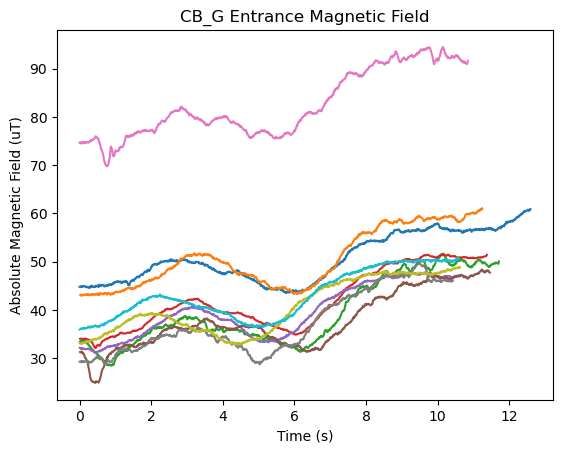

In [26]:
cb_g_templates = api.get_template_data_by_keywords(["cb_g_exit", "template"])
# In-pocket is a special case where we used an AirPods Pro to influence the magnetic field.
cb_g_templates = [t for t in cb_g_templates if "in_pocket" not in t['title']]
# We also have a template for the EXITING the CB_G, which we don't want to use.
cb_g_templates = [t for t in cb_g_templates if "exiting" not in t['title']]
print("\n".join([t['title'] for t in cb_g_templates]))
for t in cb_g_templates:
    data = t['data']
    absmag = data.mag_abs
    time_seq = data.time_seq
    plt.plot(time_seq, absmag)
plt.xlabel("Time (s)")
plt.ylabel("Absolute Magnetic Field (uT)")
plt.title("CB_G Entrance Magnetic Field")

In [27]:
"""
cb_g_exit_entering_template_2023324_1557
cb_lg_exit_entering_template_2023327_1221
composite_bldg_lg_exit_template_2023323_1226
hw_3f_door_template_maglocked_202341_2018
mwt_reddoor_template_maglocked_202341_1941
su_canteen_entrance_template_2023327_1223
"""
location_experiment_dict = {
    "CB_G_exit": "cb_g_exit_entering_template_2023324_1557",
    "CB_LG_exit": "cb_lg_exit_entering_template_2023327_1221",
    "CompositeBldg_LG_exit": "composite_bldg_lg_exit_template_2023323_1226",
    "HW_3f_door": "hw_3f_door_template_maglocked_202341_2018",
    "MWT_red_door": "mwt_reddoor_template_maglocked_202341_1941",
    "SU_canteen_entrance": "su_canteen_entrance_template_2023327_1223",
}

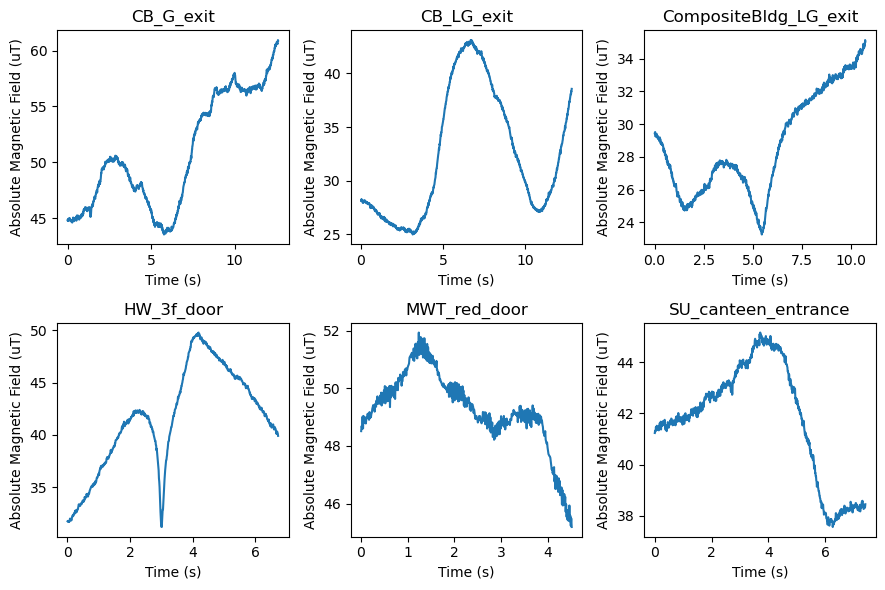

In [30]:
fig, axs = plt.subplots(2, 3, figsize=(9, 6))
row, col = 0, 0
for loc_title, experiment_name in location_experiment_dict.items():
    data = api.get_template_data(experiment_name)
    absmag = data.mag_abs
    time_seq = data.time_seq
    axs[row, col].plot(time_seq, absmag)
    axs[row, col].set_title(loc_title)
    axs[row, col].set_xlabel("Time (s)")
    axs[row, col].set_ylabel("Absolute Magnetic Field (uT)")
    col += 1
    if col == 3:
        col = 0
        row += 1
plt.tight_layout()

## 2.1 The DTW Matching approach